In [1]:
################################################################################
#                                                                              #
#                         Author: Bc. Petr Pouč                                #
#                         Date: April 4, 2024                                  #
#                         School: Brno University of Technology (BUT)          #
#                                                                              #
#         Master's Thesis: Optimization of Classification Models               #
#                         for Malicious Domain Detection                       #
#                                                                              #
################################################################################

import sys
from pathlib import Path

# Third-party libraries
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import shap

# Local imports
from loader import run
from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
from utils.preprocess import NDF

# Path setup
path_to_upper_root = '..'
if path_to_upper_root not in sys.path:
    sys.path.append(path_to_upper_root)

# Run setup
need_to_gather_data = False # set to True to rebuild the data parquet files
use_fresh_data = False # set to True to use the latest data from DB
if need_to_gather_data:
    mode = 'force-refresh' if use_fresh_data else 'auto'
    run(cache_mode=mode)

# Warnings setup
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")
warnings.filterwarnings("ignore", message="is_sparse is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated", category=FutureWarning)


2024-05-11 10:05:32.631528: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 10:05:33.227420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 10:05:34.981001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
feature_to_drop = "DEFAULT"

# Step 2: Training
(You can run only the next two cells and skip to the next step if you already have the model pickled)

Once the loader has loaded the data and applied the transformations, we can load the resulting parquets and prepare for model training. We then split the data into training and test sets and train a model.

In [4]:
#phishing = pq.read_table('floor/phishing_2307.parquet')
#benign = pq.read_table('floor/cesnet_2307.parquet')
#benign = pq.read_table('floor/benign_2307.parquet')

#benign = pq.read_table('floor/cesnet2.parquet')
#benign = pq.read_table('floor/benign_2307.parquet')
# benign = pq.read_table('floor/cesnet2.parquet')

#----------This was old way of doing it----------------
benign_old = pq.read_table('../floor/benign_2312.parquet')
phishing_old = pq.read_table('../floor/phishing_2311.parquet')

phishing_domain_names = phishing_old['domain_name']
benign_domain_names = benign_old['domain_name']

benign_old = benign_old.cast(phishing_old.schema)

# concatentate tables
data = pa.concat_tables([phishing_old, benign_old])
df = data.to_pandas()
df = df.drop(columns=['domain_name'])

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

phishing_len = len(phishing_domain_names)
benign_len = len(benign_domain_names)


#----------This is the new way of doing it----------------
#We can use the NDF class to preprocess the data
#Missing values set to -1
#Outliers are removed
#Encoding of categorical variables - Decision tree creates new feature
#Min-Max scaling, sigmoid transformation (only if cnn is used)
#Imbalance handling

malign = "../floor/benign_2312.parquet"
benign = "../floor/phishing_2311.parquet"

#The whole preprocessing step happens here
dataset = NDF("cnn", True, benign=benign, malign=malign)
class_map = dataset['class_map']

print(dataset['feature_names'])

X_train, X_test, y_train, y_test = train_test_split(torch.Tensor(dataset['features']), torch.Tensor(dataset['labels']), test_size=0.2, random_state=42)

print(X_train.shape)

#print labels of z?train, values distribution
print(y_train)
print(y_train.unique(return_counts=True))

2024-04-26 23:42:17,622 - utils.preprocess - INFO - Benign dataset path: ../floor/phishing_2311.parquet
2024-04-26 23:42:17,651 - utils.preprocess - INFO - Malign dataset path: ../floor/benign_2312.parquet


Malign dataset path: ../floor/benign_2312.parquet
Benign dataset path: ../floor/phishing_2311.parquet


/home/survivecz/.local/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/survivecz/.local/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/home/survivecz/.local/lib/python3.11/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .


Dataset Subset:
Name: dataset_../floor/phishing2311_../floor/benign2312_2024-04-26.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
1        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
2        0.0   0.000000   0.000000   0.090909   0.307692   0.083333   
3        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
4        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
5        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
6        0.0   0.142857   0.285714   0.000000   0.153846   0.000000   
7        0.0   0.071429   0.000000   0.000000   0.000000   0.000000   
8        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
9        0.0   0.142857   0.285714   0.181818   0.153846   0.041667   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_178  Feature_179  \
0        0.0        1.0        0.0  

### Histogram of TLS and RDAP features for Benign and Phishing (RELATIVE)

float64 float64 timedelta64[ms]
Feature: tls_leaf_cert_validity_len, Data Type: float64
Feature: tls_root_cert_validity_len, Data Type: float64
Feature: tls_leaf_cert_lifetime, Data Type: float64
Feature: tls_root_cert_lifetime, Data Type: float64
Feature: ip_mean_average_rtt, Data Type: float64
Feature: tls_percentage_crt_with_policies, Data Type: float64


Text(0.5, 0.98, 'Relative Frequency Histograms for Top Features')

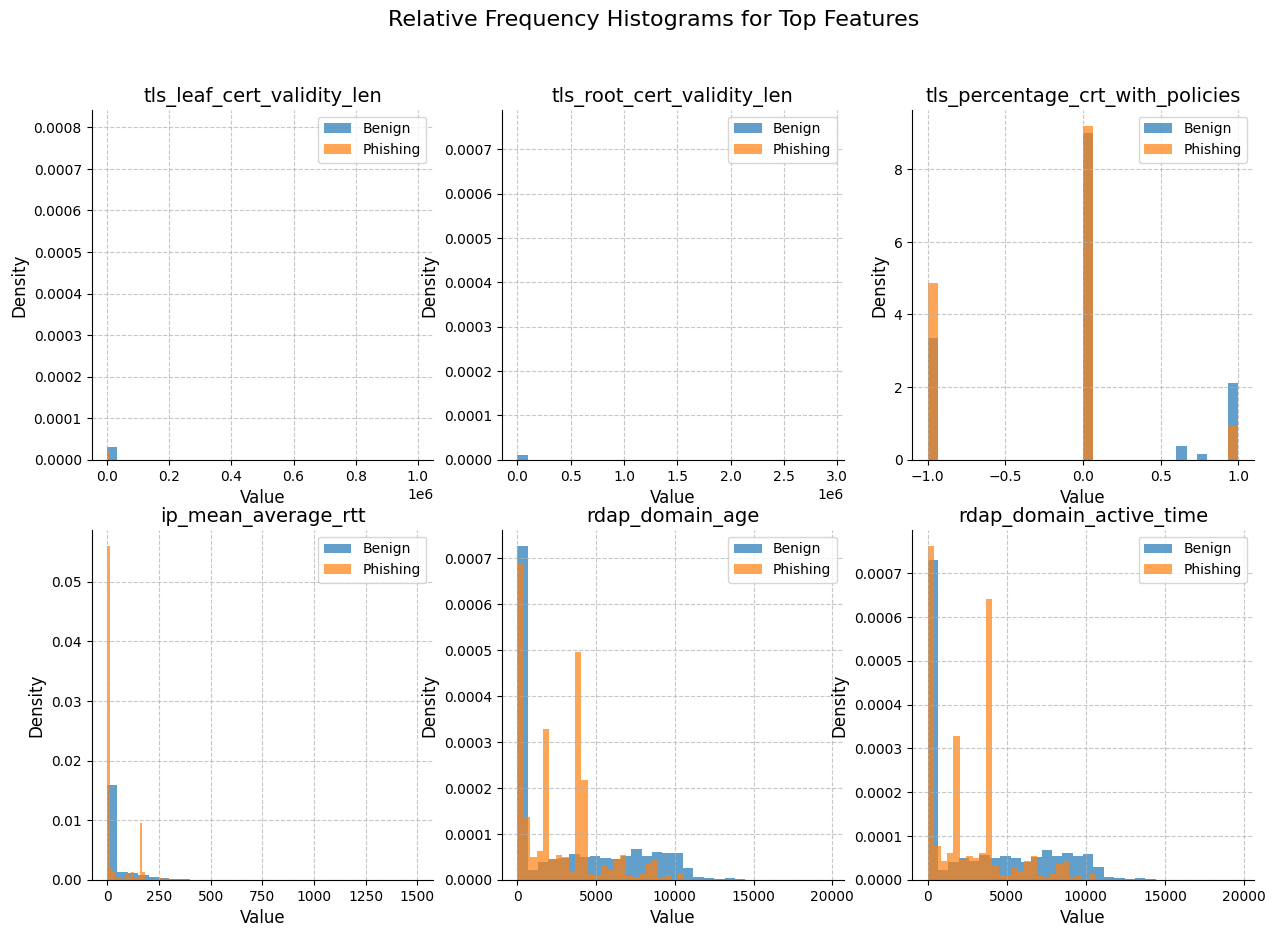

In [5]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading final dataset with domains and feature vectors
data = pq.read_table('../floor/benign_2307.parquet')
data2 = pq.read_table('../floor/phishing_2307.parquet')

# Drop nontraining columns
from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
data = drop_nontrain(data)
data2 = drop_nontrain(data2)

# Convert to pandas DataFrame
df1 = data.to_pandas()
df2 = data2.to_pandas()

print(df1['rdap_domain_age'].dtype, df1['rdap_domain_active_time'].dtype, df1['rdap_registration_period'].dtype)


# Calculate ratio of benign to phishing for features containing 'tls'
features_with_validity_len = [col for col in df1.columns if 'validity' in col]
features_with_lifetime = [col for col in df1.columns if 'lifetime' in col]
features_with_count = [col for col in df1.columns if 'count' in col]
features_with_age = [col for col in df1.columns if 'age' in col]
features_with_active_time = [col for col in df1.columns if 'active_time' in col]
features_with_period = [col for col in df1.columns if 'period' in col]

selected_features = features_with_validity_len + features_with_lifetime + features_with_age + features_with_active_time + features_with_period 
selected_features_without_age = [
    col for col in selected_features if col not in ['rdap_domain_age', 'rdap_domain_active_time', 'rdap_registration_period']
]

ratios = {}
for feature in selected_features_without_age:
    print(f"Feature: {feature}, Data Type: {df1[feature].dtype}")

    benign_count = df1[feature].count()
    phishing_count = df2[feature].count()
    
    if phishing_count != 0:
        ratio = benign_count / phishing_count
        ratios[feature] = ratio

# Convert timedelta columns to numeric representation (days) without changing names
for col in ['rdap_domain_age', 'rdap_domain_active_time', 'rdap_registration_period']:
    if pd.api.types.is_timedelta64_dtype(df1[col]):
        df1[col] = df1[col].dt.days
        df2[col] = df2[col].dt.days

# Calculate counts after converting timedelta columns to days
for col in ['rdap_domain_age', 'rdap_domain_active_time', 'rdap_registration_period']:
    benign_count = df1[col].count()
    phishing_count = df2[col].count()
    
    if phishing_count != 0:
        ratio = benign_count / phishing_count
        ratios[col] = ratio

# Sort features by ratio in descending order (including the timedelta columns)
sorted_features = sorted(ratios, key=ratios.get, reverse=True)[:9]  # Select top 9 features
custom_colors = ['#1f77b4', '#ff7f0e']  # Blue for Benign, Orange for Phishing

# Plot histograms for the top 9 features in a 3x3 subplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, feature in enumerate(sorted_features[:6]):
    ax = axes[i // 3, i % 3]  # Calculate subplot index
    
    lts_benign = df1[feature].fillna(-1.0)
    lts_phishing = df2[feature].fillna(-1.0)
    
    # Plot histograms using the custom color palette
    ax.hist(lts_benign, bins=30, alpha=0.7, label='Benign', density=True, color=custom_colors[0])
    ax.hist(lts_phishing, bins=30, alpha=0.7, label='Phishing', density=True, color=custom_colors[1])
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'{feature}', fontsize=14)
    ax.legend(prop={'size': 10})

    # Customize tick labels and font sizes
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    # Adding gridlines and removing spines
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set overall figure title
fig.suptitle('Relative Frequency Histograms for Top Features', fontsize=16)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplot layout and spacing
# plt.savefig('false_positives/images/relative_freq_histograms.png', dpi=300)  # Save the plot as a high-resolution PNG
# plt.show()

In [7]:
from xgboost import XGBClassifier
params = {
    "max_depth": 9,
    "eta": 0.15,
    "objective": "binary:logistic",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    "alpha": 0,
    "gamma": 0.1,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "lossguide",
    "max_bin": 512,
}
trees = 200

model = XGBClassifier(
  **params,
  n_estimators=trees,
  eval_metric=["error", "logloss", "auc"]
)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import cross_val_score
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


# at last, train the model
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

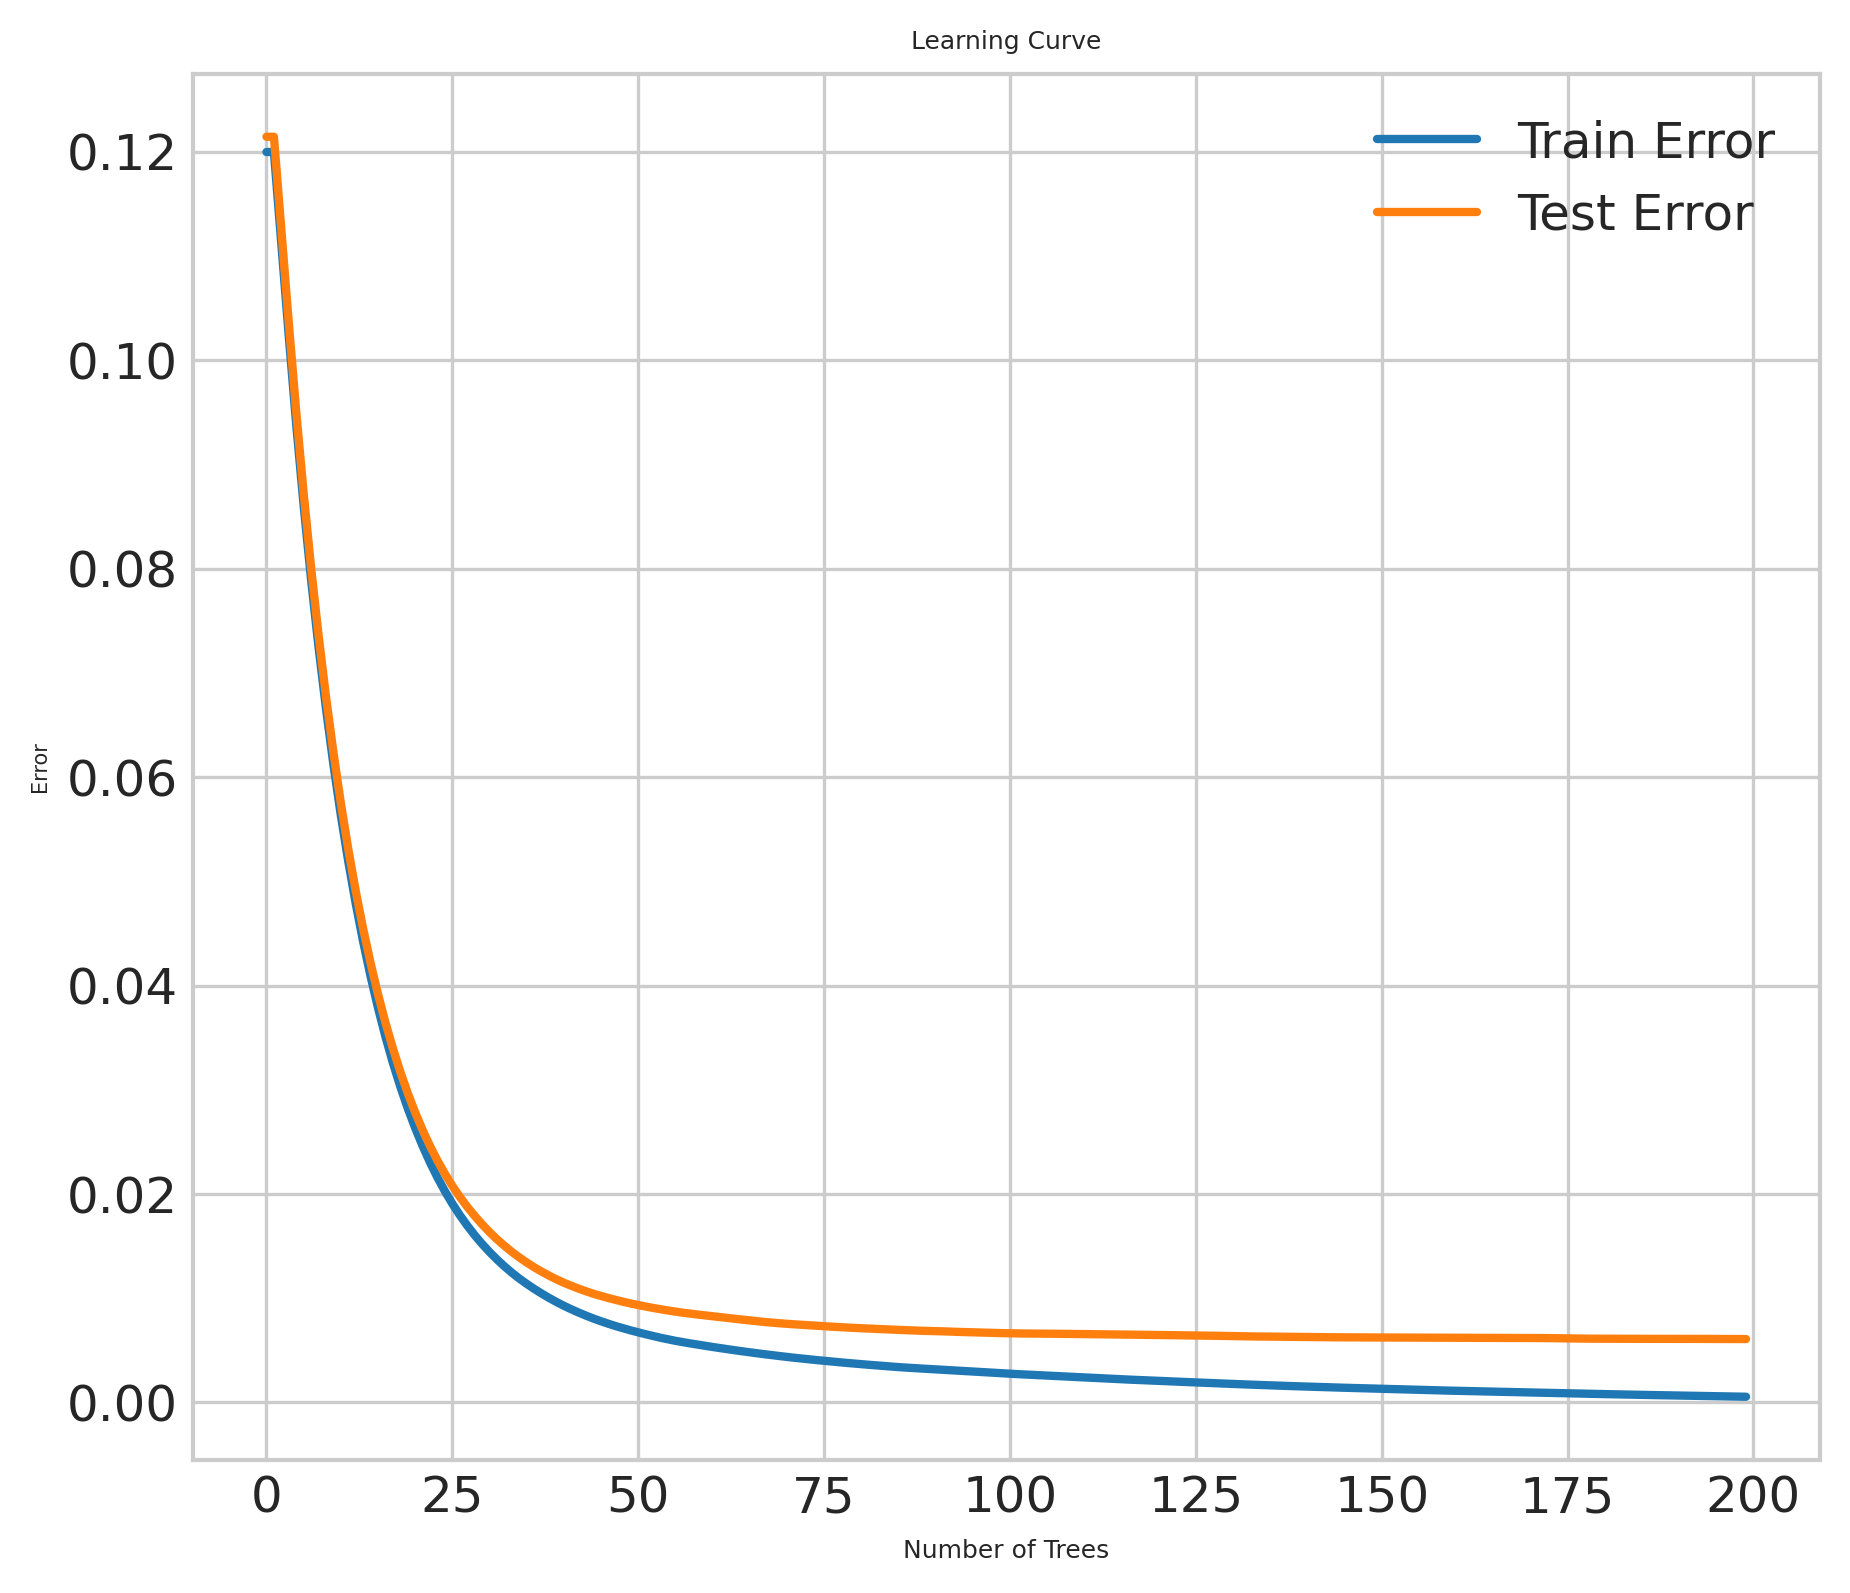

In [46]:
# plot evaluation
results = model.evals_result()
trees = len(results['validation_0']['error'])
x_axis = range(0, trees)

from matplotlib import style


# Smoothing function to reduce noise in the learning curve
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Updated function to plot the learning curve with smoothed lines
def plot_learning_curve(metric):
    # Apply modern look
    # plt.style.use('seaborn-v0_8-whitegrid')
    
    # Retrieve metric data
    train_metric = results['validation_0'][metric]
    test_metric = results['validation_1'][metric]
    
    # Apply smoothing to the metric data
    train_metric_smoothed = smooth_curve(train_metric)
    test_metric_smoothed = smooth_curve(test_metric)
    
    # Generate the plot with improved aesthetics
    fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
    ax.plot(x_axis, train_metric_smoothed, label='Train Error', linewidth=2, color='tab:blue')
    ax.plot(x_axis, test_metric_smoothed, label='Test Error', linewidth=2, color='tab:orange')
    ax.legend()
    ax.set_xlabel('Number of Trees', fontsize=6)
    ax.set_ylabel('Error' if metric == 'error' else 'Metric Value', fontsize=5)
    ax.set_title('Learning Curve', fontsize=6)
    plt.show()

# Plotting the smoothed learning curve for 'error'
plot_learning_curve('error')

In [9]:
"""
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
scores
"""

"\npd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\nscores\n"

Either way, now you should have a trained model ready to use. Let's save it first, so we can use it later.

In [10]:
pickle.dump(model, open("xgboost_model.pickle.dat", "wb"))

# Save X_train to a pickle file
with open('X_train.pickle.dat', 'wb') as file:
  pickle.dump(X_train, file)

# Save Y_train to a pickle file
with open('y_train.pickle.dat', 'wb') as file:
  pickle.dump(y_train, file)

# Step 3: Evaluating the model's performance
(You can run the next cell only and then skip to the next step if you just want to play with SHAP)

We can now load the model at any time and use it to make predictions. We can also evaluate its performance on the test set. The following cell will load the model and evaluate it on the test set. It will also print the confusion matrix and classification report.

In [11]:
model = pickle.load(open("xgboost_model.pickle.dat", "rb"))

0.9746708119970738
              precision    recall  f1-score   support

         0.0     0.9948    0.9983    0.9965     80118
         1.0     0.9871    0.9625    0.9747     11074

    accuracy                         0.9939     91192
   macro avg     0.9910    0.9804    0.9856     91192
weighted avg     0.9939    0.9939    0.9939     91192



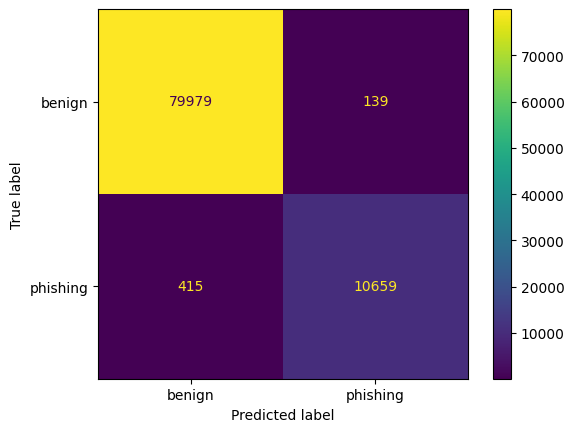

In [12]:
predicted = model.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, predicted, digits=4))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['benign', 'phishing'], values_format='d')

#save as png to false_positives/images
# plt.savefig('false_positives/images/confusion_matrix.png')

# Step 4: Explaining the model's predictions
(You can start from the cell where the pickled shap values are loaded if you already have them)

We can now use SHAP to gain insight into the model's predictions. First, shap values need to be computed for the test set. This is a computationally expensive process, but in practice, you can significantly reduce the time needed by using a narrower sample of the data, without affecting the results much. The following cell will compute shap values for the test set. It will also save the shap values to a file, so you can load them later without having to recompute them.

In [13]:
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))

The shap values are now stored. You can later start all the way here (after running the mandatory cells in previous steps) to only play with SHAP.

In [14]:
shap_values = pickle.load(open("shap_values.pickle.dat", "rb"))

In [15]:
shap.initjs()
reverse_class_map = {v: k for k, v in class_map.items()}

## Force plot
The force plot shows the shap values for a single prediction. The values are sorted by their absolute value, so the most important features are the largest arrows. The color indicates the influence of the feature. The red color indicates a positive value, while the blue color indicates a negative value. The base value is the average prediction for the whole dataset. The output value is the prediction for the selected sample. The sum of the base value and the shap values is equal to the output value. You can see how each feature "forces" the shap value to its final resting position, determining the resulting prediction.

Note that the force plot is interactive, but that breaks with widgets. So instead just change the sample variable to see different samples and rerun the cell.

In [16]:
def get_feature_with_highest_shap(shap_values, feature_names, sample_index):
    # Compute the absolute SHAP values for the sample
    abs_shap_values = np.abs(shap_values[sample_index, :])
    
    # Find the index of the highest SHAP value
    highest_shap_index = np.argmax(abs_shap_values)

    # Use the index to get the feature name from the provided list
    feature_name = feature_names[highest_shap_index]
    feature_value = dataset[sample_index, highest_shap_index].item()  

    return feature_name, feature_value

## Creating force plots for each sample + getting feature with highest shap value

In [17]:
# import matplotlib.pyplot as plt
# import os
# import numpy as np

# # Indexes of all false positives
# print(f'FP indexes: {domain_names_dict.values()}')

# # Print all possible indexes to ../false_positives/indexes.txt
# list_of_indexes = []
# with open('false_positives/indexes.txt', 'w') as f:
#     for item in X_test.index:
#         f.write("%s\n" % item)
#         list_of_indexes.append(item)

# # Index of FP in the dataframe is not the same as the index of FP in X_test, so we need to convert it
# FP_index_xtest = [i for i, x in enumerate(list_of_indexes) if x in domain_names_dict.values()]
# FP_index_xtest = [i + 1 for i in FP_index_xtest]

# FP_index = list_of_indexes.index(49178) + 1
# # The same way, create a list FP_index with all false positive indexes

# if not os.path.exists('false_positives/force_plots'):
#     os.makedirs('false_positives/force_plots')

# # Create a dictionary to store the highest SHAP values for each false positive
# highest_shap_values = {}
# feature_names = []
# plt.figure(figsize=(8, 6))
# # SHAP force plot for all FP in FP_index_xtest and save them to ../false_positives/FP_force_plots as pdf

# for i in FP_index_xtest:
#     #print len of FP_index_xtest
#     feature_name, adjusted_feature_value = get_feature_with_highest_shap(shap_values, X_test, i)
#     # Get domain name from list_of_indexes
#     domain_name_index = list_of_indexes[i - 1]
#     domain_name = list(domain_names_dict.keys())[list(domain_names_dict.values()).index(domain_name_index)]
#     #print("Feature with Highest SHAP Value for %s: %s (%.2f)" % (domain_name, feature_name, adjusted_feature_value))
    
#     # Save the highest SHAP values to the dictionary
#     highest_shap_values[domain_name] = (feature_name, adjusted_feature_value)
#     feature_names.append(feature_name)
    
#     shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], show=False, matplotlib=True)
#     plt.savefig('false_positives/force_plots/FP_force_plot_' + str(i) + '.pdf', bbox_inches='tight')
#     plt.close()

#     # Create an Explanation object
#     expl = shap.Explanation(values=shap_values[i, :],
#                            base_values=explainer.expected_value,
#                            data=X_test.iloc[i, :],
#                            feature_names=X_test.columns)

#     # Check if the directory to save the waterfall plots exists, if not create it
#     if not os.path.exists('false_positives/waterfall_plots'):
#         os.makedirs('false_positives/waterfall_plots')
    
#     # Save the SHAP waterfall plot to ../false_positives/waterfall_plots as pdf
#     plt.figure()
#     shap.waterfall_plot(expl, show=False)
#     plt.savefig(f'false_positives/waterfall_plots/FP_waterfall_plot_{i}.pdf', bbox_inches='tight')
#     plt.close()

# # Sort the dictionary by adjusted_feature_value in descending order
# sorted_highest_shap_values = dict(sorted(highest_shap_values.items(), key=lambda x: x[1][1], reverse=True))

# # Save the sorted highest SHAP values to /false_positives/highest_shap.txt
# with open('false_positives/highest_shap.txt', 'w') as f:
#     for domain_name, (feature_name, adjusted_feature_value) in sorted_highest_shap_values.items():
#         f.write("Domain: %s, Feature: %s, SHAP Value: %.2f\n" % (domain_name, feature_name, adjusted_feature_value))

# #print feature_names
# print(feature_names)

In [18]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from collections import Counter

# def read_shap_data(filepath):
#     feature_shap_values = {}
#     feature_shap_count = {}  # Initializing a dictionary to hold feature counts
#     domain_names = {}

#     with open(filepath, 'r') as f:
#         for line in f:
#             parts = line.strip().split(', ')
#             domain_name = parts[0].split(': ')[1]
#             feature_name = parts[1].split(': ')[1]
#             shap_value = float(parts[2].split(': ')[1])

#             feature_shap_values.setdefault(feature_name, []).append(shap_value)
#             feature_shap_count[feature_name] = feature_shap_count.get(feature_name, 0) + 1  # Incrementing the feature count
#             domain_names.setdefault(feature_name, []).append(domain_name)  # Changed key to feature_name only

#     return feature_shap_values, feature_shap_count, domain_names

# def summarize_shap_values(feature_shap_values, feature_shap_count, domain_names):
#     feature_summary = {
#         'Feature': [],
#         'Most Common SHAP Value': [],
#         'Count': [],
#         'Domains': []
#     }

#     for feature_name, shap_values in feature_shap_values.items():
#         most_common_value, most_common_count = Counter(shap_values).most_common(1)[0]
#         domains = domain_names.get(feature_name, [])  # Updated to use feature_name as key
#         feature_summary['Feature'].append(feature_name)
#         feature_summary['Most Common SHAP Value'].append(most_common_value)
#         feature_summary['Count'].append(feature_shap_count[feature_name])  # Adding the feature count here
#         feature_summary['Domains'].append(", ".join(domains))  # Join domain names into a string

#     return pd.DataFrame(feature_summary)

# def visualize_summary(summary_df):
#     sns.set(style="whitegrid", font_scale=1.2)  # Set the style to whitegrid and increase font scale
    
#     plt.figure(figsize=(20, 12))
#     vibrant_palette = sns.color_palette("bright", n_colors=len(summary_df))
    
#     sns.barplot(data=summary_df, x='Feature', y='Most Common SHAP Value', palette=vibrant_palette)
    
#     plt.yscale('log')
#     plt.title('Most Common SHAP Values by Feature (Log Scale)', fontsize=24)
#     plt.xticks(rotation=45, ha="right", fontsize=16)
#     plt.yticks(fontsize=16)
#     plt.tight_layout()
#     plt.xlabel('Feature', fontsize=20)
#     plt.ylabel('Most Common SHAP Value (log scale)', fontsize=20)
    
#     plt.savefig('false_positives/images/most_common_shap_values.pdf', bbox_inches='tight')
#     plt.show()


# # Main execution
# filepath = 'false_positives/highest_shap.txt'
# feature_shap_values, feature_shap_count, domain_names = read_shap_data(filepath)
# summary_df = summarize_shap_values(feature_shap_values, feature_shap_count, domain_names)
# summary_df = summary_df.sort_values(by='Most Common SHAP Value', ascending=False)


# summary_df['Domains'] = summary_df['Domains'].str.split(', ')
# summary_df = summary_df.explode('Domains')
    
# summary_df.to_excel('false_positives/summary_df.xlsx', index=False)  # Saving summary_df to excel
# print(summary_df)
# visualize_summary(summary_df)

### Feature Importance (directly extracted from the model)

XGBoost has a built-in function to plot feature importance directly. The variable `feature_importances` holds the importance scores derived from the machine learning model. These scores signify the contribution of each feature to the model's predictive performance.

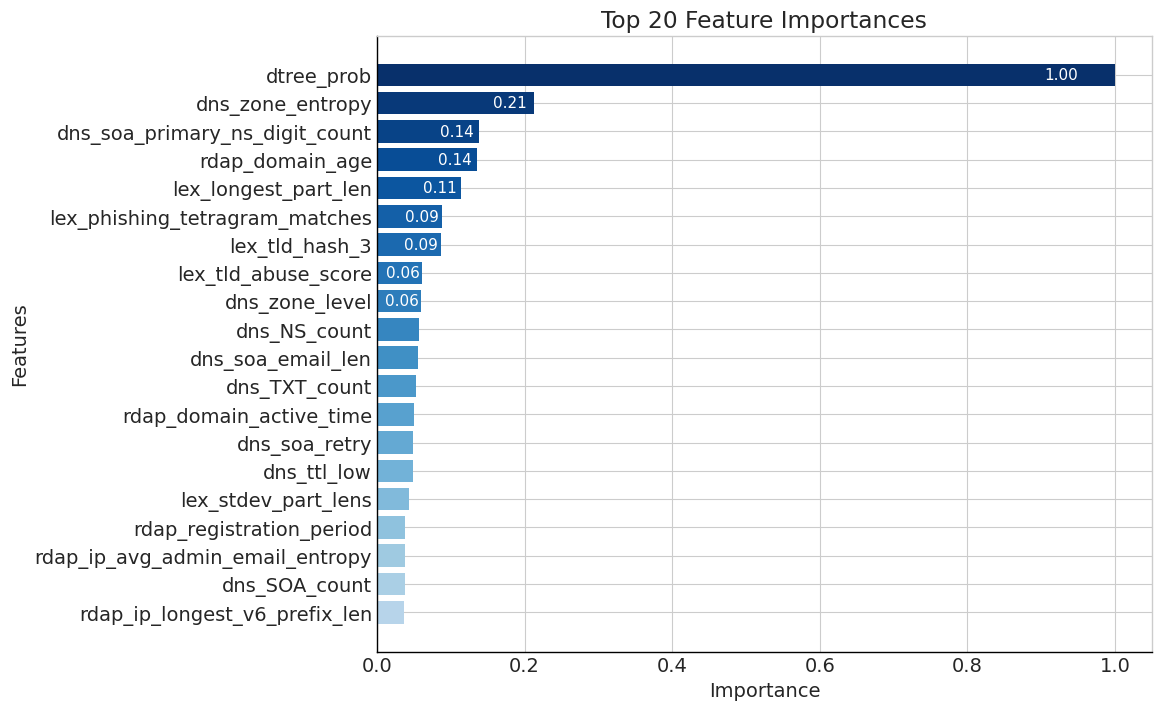

In [40]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14})


feature_names = dataset['feature_names'] if 'feature_names' in dataset else [f"Feature {i}" for i in range(len(model.feature_importances_))]
feature_importances = model.feature_importances_
normalized_importances = (feature_importances - np.min(feature_importances)) / (np.max(feature_importances) - np.min(feature_importances))
sorted_indices = np.argsort(feature_importances)[::-1]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_names[i] for i in top_20_indices]
top_20_normalized_importances = normalized_importances[top_20_indices]

plt.figure(figsize=(10, 8))
colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_20_normalized_importances)))
bars = plt.barh(top_20_feature_names, top_20_normalized_importances, color=colors)

# Adjusted value labels placement to be inside or outside based on the bar width
for bar, value in zip(bars, top_20_normalized_importances):
    bar_width = bar.get_width()
    threshold = 0.06 
    if bar_width > threshold:  
        text_position = bar_width - 0.05 * bar_width  
        plt.text(text_position, bar.get_y() + bar.get_height() / 2, f"{value:.2f}", va='center', ha='right', color='white', fontsize=11)
    else: 
        pass

plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1)


plt.savefig('../top_20_feature_importances.png', dpi=600, bbox_inches='tight')
plt.show()


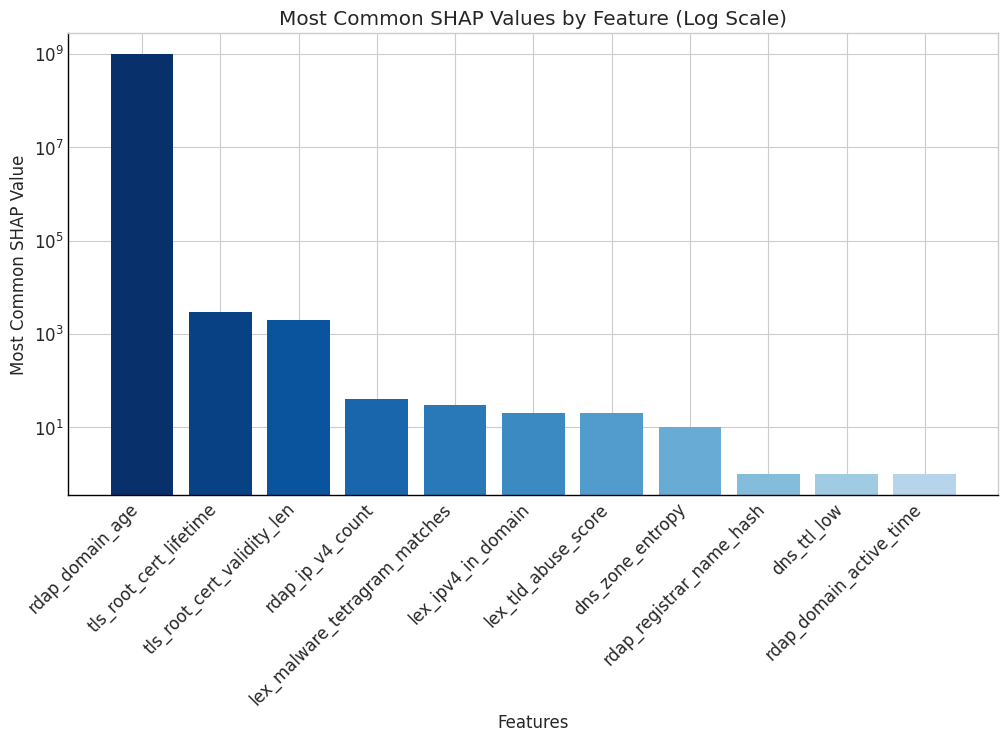

In [44]:
plt.rcParams.update({'font.size': 12})
features_log = [
    'rdap_domain_age', 'tls_root_cert_lifetime', 'tls_root_cert_validity_len', 'rdap_ip_v4_count','lex_malware_tetragram_matches','lex_ipv4_in_domain','lex_tld_abuse_score','dns_zone_entropy','rdap_registrar_name_hash','dns_ttl_low','rdap_domain_active_time'
]

# these values are here, because i forgot how i made this plot in the past, dont worry, its exact coppy, just wanted to adjust font size
shap_values_log = [
    1e9,  # top bar reaches 10^9
    3e3,  # next bar is roughly a third the height on a log scale
    2e3,  # next bar reaches 10^8
    4e1,  # and so on...
    3e1,
    2e1,
    2e1,
    1e1,
    1e0,
    1e0,
    1e0
  # smallest bar reaches 10^2
]

# Create a bar chart with a log scale on the y-axis to reflect the actual values
plt.figure(figsize=(12, 6))

# Set log scale for y-axis
plt.yscale('log')

# Create vertical bars
colors = plt.cm.Blues(np.linspace(1, 0.3, len(shap_values_log)))

bars_log = plt.bar(features_log, shap_values_log, color=colors)

# Setting the title and labels
plt.title('Most Common SHAP Values by Feature (Log Scale)')
plt.xlabel('Features')
plt.ylabel('Most Common SHAP Value')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')

# Remove the spines for a cleaner look
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1)

# plt.tight_layout()
plt.savefig('../most_common_shap_values.png', dpi=800, bbox_inches='tight')

plt.show()


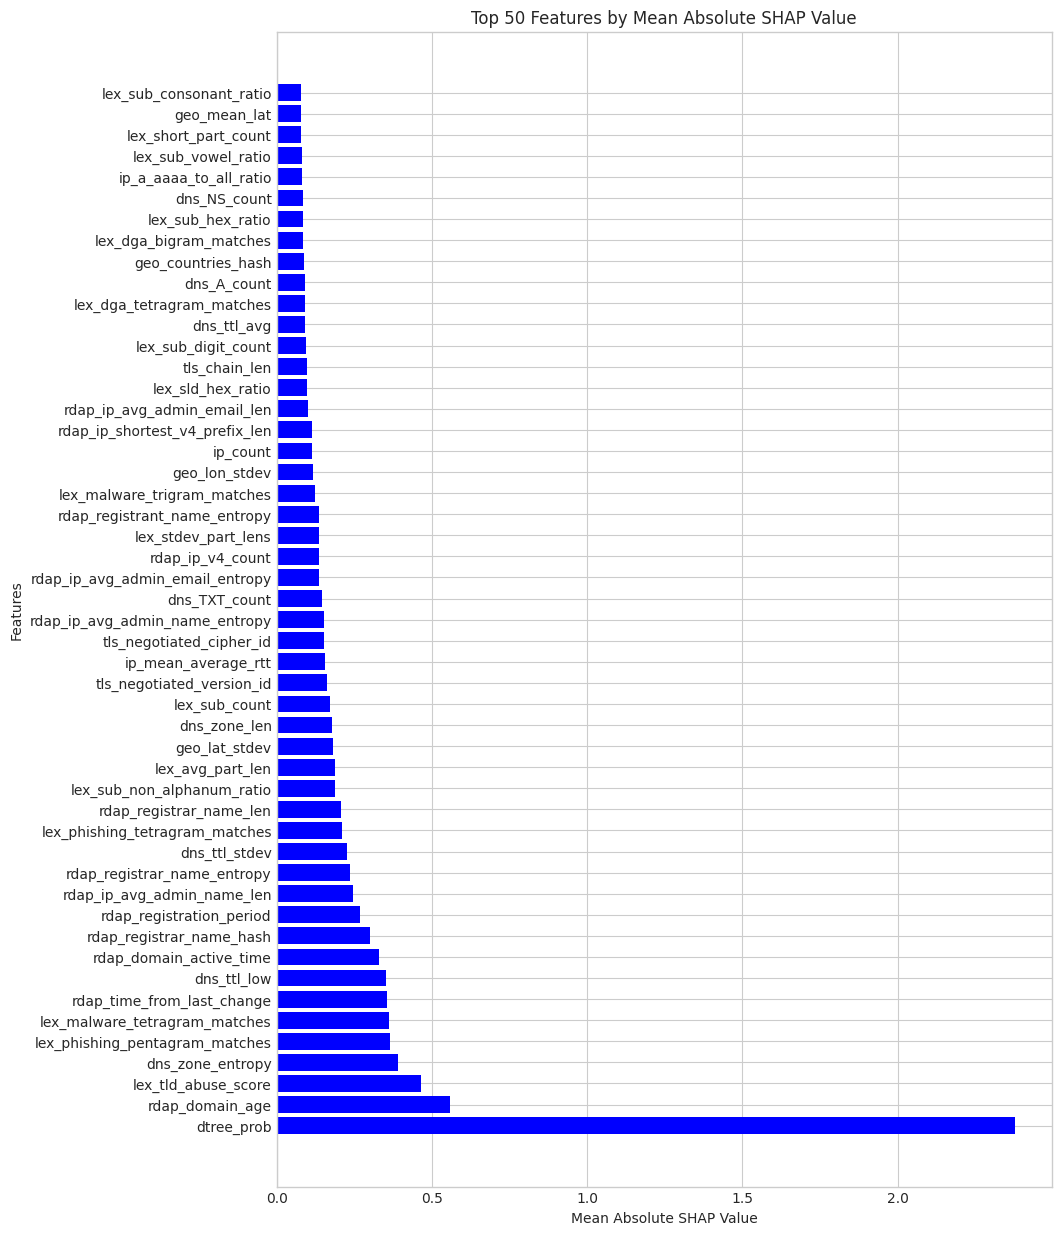

In [21]:

explainer = shap.TreeExplainer(model)
X_test_numpy = X_test.numpy()

# Calculate SHAP values for the X_test dataset
shap_values = explainer.shap_values(X_test_numpy)
shap.initjs()

# Plot a force plot for the first sample
shap.force_plot(explainer.expected_value, shap_values[0], X_test_numpy[0])

# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
top_50_indices = sorted_indices[:50]

# Assuming dataset['feature_names'] exists and matches the features used in the model
feature_names = dataset['feature_names']

# Get the names of the top 50 features
top_50_feature_names = np.array(feature_names)[top_50_indices]

# Get their corresponding mean absolute SHAP values
top_50_shap_values = mean_abs_shap_values[top_50_indices]

# Plotting the top 50 features
plt.figure(figsize=(10, 15))
plt.title("Top 50 Features by Mean Absolute SHAP Value")
plt.barh(range(50), top_50_shap_values[::-1], color='blue')
plt.yticks(range(50), top_50_feature_names[::-1])
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.show()


# Summary plot
The summary plot shows (in dot or violin mode) how individual feature values are distributed for each feature. The x-axis shows the shap value, while the color shows the feature value. The features are sorted by their importance, so the most important features are at the top. The color indicates the value of the feature. The red color indicates a high value, while the blue color indicates a low value. The zero line is the split point between outputs, just like the base value in the force plot. For some features, you might see that low values usually result in negative classification, while high values usually result in positive classification.

Another mode, bar, shows a mean shap value across all data points, which is effectively a plot of feature importance. Use the widgets to switch between modes and feature count. Also note that the violin and dot plots take a while to calculate, so you might want to start with a low feature count.

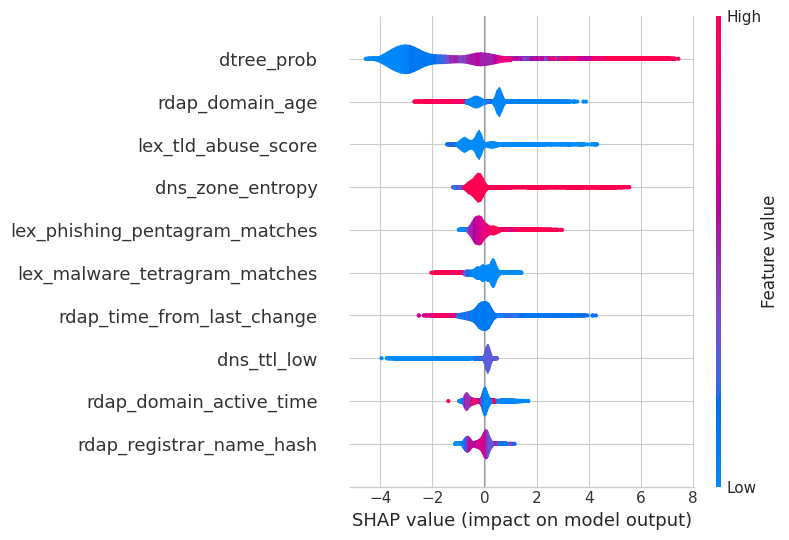

In [22]:
explainer = shap.TreeExplainer(model)
X_sample = X_test.numpy() if hasattr(X_test, 'numpy') else X_test 

shap_values = explainer.shap_values(X_sample)

# Save the SHAP values for later use
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))
feature_names = dataset['feature_names'] if 'dataset' in locals() or 'dataset' in globals() else None

def plot_violin_shap(shap_values, X_sample, feature_names=None, max_display=10):
    """
    Plot a SHAP summary violin plot for the specified number of features.

    :param shap_values: The SHAP values calculated for the dataset.
    :param X_sample: The dataset (numpy array or similar) used for SHAP value calculation.
    :param feature_names: Optional list of feature names corresponding to columns in X_sample.
    :param max_display: The number of top features to display (default is 10).
    """
    shap.summary_plot(shap_values, X_sample, plot_type='violin', feature_names=feature_names, max_display=max_display)

# Example usage: Plot the top 10 features by default
plot_violin_shap(shap_values, X_sample, feature_names=feature_names)

In [23]:
# get gain score
score = model.get_booster().get_score(importance_type='gain')
feature_names = dataset['feature_names'] if 'dataset' in locals() or 'dataset' in globals() else None

# Combine feature names with their corresponding gain scores and sort the list
sorted_score_with_names = [(feature_names[int(idx[1:])], gain_score) for idx, gain_score in score.items()]
sorted_score_with_names = sorted(sorted_score_with_names, key=lambda x: x[1], reverse=True)

sorted_score_with_names


[('dtree_prob', 362.54217529296875),
 ('dns_zone_entropy', 77.2652816772461),
 ('dns_soa_primary_ns_digit_count', 50.141845703125),
 ('rdap_domain_age', 49.181182861328125),
 ('lex_longest_part_len', 41.31005859375),
 ('lex_phishing_tetragram_matches', 32.012977600097656),
 ('lex_tld_hash_3', 31.59370231628418),
 ('lex_tld_abuse_score', 22.007261276245117),
 ('dns_zone_level', 21.77096176147461),
 ('dns_NS_count', 20.57620620727539),
 ('dns_soa_email_len', 20.29884910583496),
 ('dns_TXT_count', 19.221567153930664),
 ('rdap_domain_active_time', 18.11249351501465),
 ('dns_soa_retry', 17.883895874023438),
 ('dns_ttl_low', 17.823400497436523),
 ('lex_stdev_part_lens', 15.570363998413086),
 ('rdap_registration_period', 13.658345222473145),
 ('rdap_ip_avg_admin_email_entropy', 13.588052749633789),
 ('dns_SOA_count', 13.55603313446045),
 ('rdap_ip_longest_v6_prefix_len', 13.548095703125),
 ('lex_malware_tetragram_matches', 13.316919326782227),
 ('lex_phishing_pentagram_matches', 13.1182584762